In [46]:
import pandas as pd

In [59]:
df_test = pd.read_csv("can1.csv")
df_test.sort_values("tr",inplace=True)
#df_test.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
df_test = df_test.groupby(["seq","modifications"], as_index=False).median()

In [60]:
df_train = pd.read_csv("can9.csv")
df_train.sort_values("tr",inplace=True)
#df_train.drop_duplicates(subset=["seq","modifications"],keep="first",inplace=True)
df_train = df_train.groupby(["seq","modifications"], as_index=False).median()

In [61]:
# Make sure we have no NA in the dataframes
df_test['modifications'] = df_test['modifications'].fillna("")
df_train['modifications'] = df_train['modifications'].fillna("")

In [50]:
# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer

# Default
from collections import Counter
import os
import urllib.request

# specific packages
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np

import tensorflow as tf
from tensorflow.python.eager import context

import warnings
warnings.filterwarnings('ignore')

In [6]:
# obtain three models for deeplc
urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5",
    "full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"
)

urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5",
    "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5"
)

urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5",
    "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
)

('full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5',
 <http.client.HTTPMessage at 0x26e03cb60e0>)

In [55]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        path_model=["full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5",
                    "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",
                    "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"],
        batch_num=1024000,
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_calib = dlc.make_preds(seq_df=df_test)

mae_calib = sum(abs(df_test["tr"]-preds_calib))/len(df_test["tr"].index)
perc95_calib = np.percentile(abs(df_test["tr"]-preds_calib),95)*2
cor_calib = pearsonr(df_test["tr"],preds_calib)[0]

14/14 [==============================] - 2s 112ms/step


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\function.py", line 305, in __del__
    context.remove_function(self.name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 2740, in remove_function
    context().remove_function(name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 1384, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_548141'.


1/1 [==============================] - 0s 436ms/step


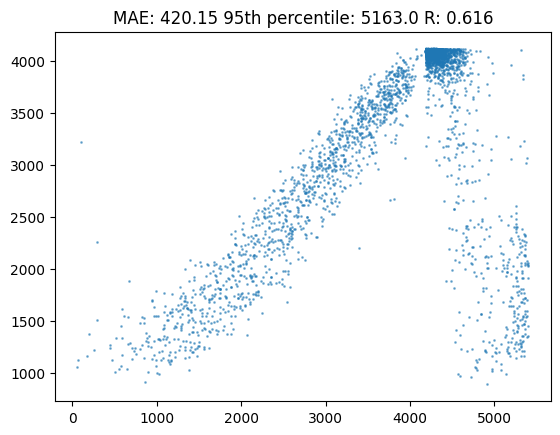

In [56]:
%matplotlib inline

plt.title(f"MAE: {round(mae_calib,2)} 95th percentile: {round(perc95_calib,2)} R: {round(cor_calib,3)}")
plt.scatter(df_test["tr"],preds_calib,s=1,alpha=0.5)
plt.show()

In [57]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[
        "full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5",
        "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",
        "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
    ],
    freeze_layers=False,
    n_epochs=50,
    freeze_after_concat=1
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\function.py", line 305, in __del__
    context.remove_function(self.name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 2740, in remove_function
    context().remove_function(name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 1384, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_568806'.


Epoch 1/50
451/451 [==============================] - 15s 29ms/step - loss: 0.2013 - mean_absolute_error: 0.1757 - val_loss: 0.1489 - val_mean_absolute_error: 0.1240
Epoch 2/50
451/451 [==============================] - 12s 26ms/step - loss: 0.1483 - mean_absolute_error: 0.1239 - val_loss: 0.1370 - val_mean_absolute_error: 0.1131
Epoch 3/50
451/451 [==============================] - 12s 26ms/step - loss: 0.1421 - mean_absolute_error: 0.1185 - val_loss: 0.1354 - val_mean_absolute_error: 0.1121
Epoch 4/50
451/451 [==============================] - 12s 27ms/step - loss: 0.1310 - mean_absolute_error: 0.1079 - val_loss: 0.1433 - val_mean_absolute_error: 0.1204
Epoch 5/50
451/451 [==============================] - 12s 27ms/step - loss: 0.1268 - mean_absolute_error: 0.1040 - val_loss: 0.1371 - val_mean_absolute_error: 0.1144
Epoch 6/50
451/451 [==============================] - 12s 26ms/step - loss: 0.1254 - mean_absolute_error: 0.1027 - val_loss: 0.1246 - val_mean_absolute_error: 0.1021
Epoc

KeyboardInterrupt: 

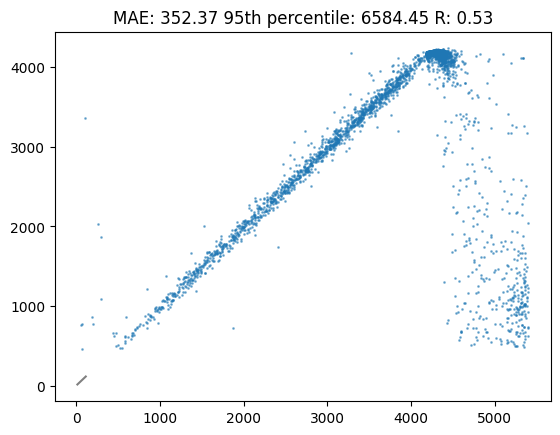

In [45]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

In [51]:
# obtain three models for deeplc
urllib.request.urlretrieve(
    "https://github.com/RobbinBouwmeester/DeepLCModels/blob/main/full_hc_TMTpro_train_msv000088167_median_1fd8363d9af9dcad3be7553c39396960.hdf5?raw=true",
    "full_hc_TMTpro_train_msv000088167_median_1fd8363d9af9dcad3be7553c39396960.hdf5"
)

urllib.request.urlretrieve(
    "https://github.com/RobbinBouwmeester/DeepLCModels/raw/main/full_hc_TMTpro_train_msv000088167_median_8c22d89667368f2f02ad996469ba157e.hdf5?raw=true",
    "full_hc_TMTpro_train_msv000088167_median_8c22d89667368f2f02ad996469ba157e.hdf5"
)

urllib.request.urlretrieve(
    "https://github.com/RobbinBouwmeester/DeepLCModels/blob/main/full_hc_TMTpro_train_msv000088167_median_cb975cfdd4105f97efa0b3afffe075cc.hdf5?raw=true",
    "full_hc_TMTpro_train_msv000088167_median_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
)

('full_hc_TMTpro_train_msv000088167_median_cb975cfdd4105f97efa0b3afffe075cc.hdf5',
 <http.client.HTTPMessage at 0x26ef930a5f0>)

In [52]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[
        "full_hc_TMTpro_train_msv000088167_median_1fd8363d9af9dcad3be7553c39396960.hdf5",
        "full_hc_TMTpro_train_msv000088167_median_8c22d89667368f2f02ad996469ba157e.hdf5",
        "full_hc_TMTpro_train_msv000088167_median_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
    ],
    freeze_layers=False,
    n_epochs=10,
    freeze_after_concat=1
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\function.py", line 305, in __del__
    context.remove_function(self.name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 2740, in remove_function
    context().remove_function(name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 1384, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_predict_function_451364'.


Epoch 1/10
451/451 [==============================] - 14s 28ms/step - loss: 0.2466 - mean_absolute_error: 0.2138 - val_loss: 0.1850 - val_mean_absolute_error: 0.1526
Epoch 2/10
451/451 [==============================] - 11s 25ms/step - loss: 0.2007 - mean_absolute_error: 0.1685 - val_loss: 0.1707 - val_mean_absolute_error: 0.1387
Epoch 3/10
451/451 [==============================] - 11s 24ms/step - loss: 0.1848 - mean_absolute_error: 0.1531 - val_loss: 0.2727 - val_mean_absolute_error: 0.2412
Epoch 4/10
451/451 [==============================] - 11s 24ms/step - loss: 0.1833 - mean_absolute_error: 0.1519 - val_loss: 0.1607 - val_mean_absolute_error: 0.1296
Epoch 5/10
451/451 [==============================] - 11s 25ms/step - loss: 0.1809 - mean_absolute_error: 0.1499 - val_loss: 0.1579 - val_mean_absolute_error: 0.1270
Epoch 6/10
451/451 [==============================] - 11s 24ms/step - loss: 0.1687 - mean_absolute_error: 0.1380 - val_loss: 0.2049 - val_mean_absolute_error: 0.1744
Epoc

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\function.py", line 305, in __del__
    context.remove_function(self.name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 2740, in remove_function
    context().remove_function(name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 1384, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_train_function_454723'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\func

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\function.py", line 305, in __del__
    context.remove_function(self.name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 2740, in remove_function
    context().remove_function(name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 1384, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_flat_map_slice_batch_indices_504476'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensor

1/1 [==============================] - 0s 408ms/step


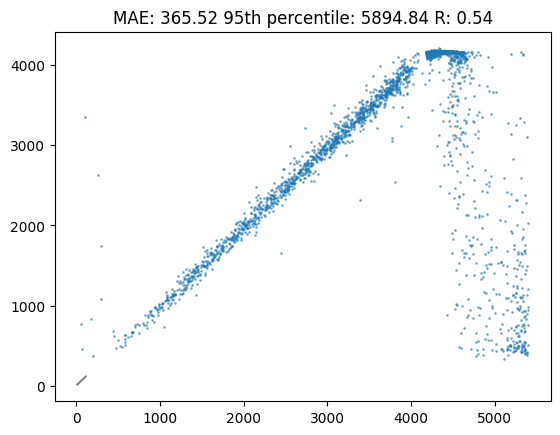

In [53]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

In [62]:
# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

df_train = df_train[df_train["tr"] < 4100]
df_test = df_test[df_test["tr"] < 4100]

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[
        "full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5",
        "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",
        "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
    ],
    freeze_layers=False,
    n_epochs=50,
    freeze_after_concat=1
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

Epoch 1/50
451/451 [==============================] - 14s 26ms/step - loss: 0.2010 - mean_absolute_error: 0.1756 - val_loss: 0.1472 - val_mean_absolute_error: 0.1224
Epoch 2/50
451/451 [==============================] - 11s 25ms/step - loss: 0.1462 - mean_absolute_error: 0.1219 - val_loss: 0.1437 - val_mean_absolute_error: 0.1197
Epoch 3/50
451/451 [==============================] - 12s 27ms/step - loss: 0.1420 - mean_absolute_error: 0.1183 - val_loss: 0.1276 - val_mean_absolute_error: 0.1041
Epoch 4/50
451/451 [==============================] - 11s 25ms/step - loss: 0.1288 - mean_absolute_error: 0.1055 - val_loss: 0.1274 - val_mean_absolute_error: 0.1043
Epoch 5/50
451/451 [==============================] - 12s 26ms/step - loss: 0.1283 - mean_absolute_error: 0.1054 - val_loss: 0.1274 - val_mean_absolute_error: 0.1046
Epoch 6/50
451/451 [==============================] - 12s 26ms/step - loss: 0.1224 - mean_absolute_error: 0.0997 - val_loss: 0.1253 - val_mean_absolute_error: 0.1027
Epoc

451/451 [==============================] - 12s 26ms/step - loss: 0.0875 - mean_absolute_error: 0.0673 - val_loss: 0.1142 - val_mean_absolute_error: 0.0940
Epoch 1/50
451/451 [==============================] - 15s 29ms/step - loss: 0.1883 - mean_absolute_error: 0.1567 - val_loss: 0.1476 - val_mean_absolute_error: 0.1165
Epoch 2/50
451/451 [==============================] - 13s 28ms/step - loss: 0.1448 - mean_absolute_error: 0.1145 - val_loss: 0.1299 - val_mean_absolute_error: 0.1002
Epoch 3/50
451/451 [==============================] - 12s 27ms/step - loss: 0.1352 - mean_absolute_error: 0.1059 - val_loss: 0.1411 - val_mean_absolute_error: 0.1120
Epoch 4/50
451/451 [==============================] - 12s 27ms/step - loss: 0.1275 - mean_absolute_error: 0.0985 - val_loss: 0.1218 - val_mean_absolute_error: 0.0932
Epoch 5/50
451/451 [==============================] - 12s 27ms/step - loss: 0.1273 - mean_absolute_error: 0.0987 - val_loss: 0.1245 - val_mean_absolute_error: 0.0961
Epoch 6/50
451/

451/451 [==============================] - 12s 27ms/step - loss: 0.0889 - mean_absolute_error: 0.0655 - val_loss: 0.1321 - val_mean_absolute_error: 0.1085
Epoch 50/50
451/451 [==============================] - 12s 26ms/step - loss: 0.0886 - mean_absolute_error: 0.0652 - val_loss: 0.1121 - val_mean_absolute_error: 0.0891
Epoch 1/50
451/451 [==============================] - 15s 30ms/step - loss: 0.2431 - mean_absolute_error: 0.1890 - val_loss: 0.1777 - val_mean_absolute_error: 0.1296
Epoch 2/50
451/451 [==============================] - 13s 28ms/step - loss: 0.1717 - mean_absolute_error: 0.1276 - val_loss: 0.1547 - val_mean_absolute_error: 0.1134
Epoch 3/50
451/451 [==============================] - 13s 29ms/step - loss: 0.1530 - mean_absolute_error: 0.1138 - val_loss: 0.1538 - val_mean_absolute_error: 0.1163
Epoch 4/50
451/451 [==============================] - 13s 29ms/step - loss: 0.1521 - mean_absolute_error: 0.1157 - val_loss: 0.1454 - val_mean_absolute_error: 0.1103
Epoch 5/50
451

451/451 [==============================] - 13s 30ms/step - loss: 0.0985 - mean_absolute_error: 0.0716 - val_loss: 0.1164 - val_mean_absolute_error: 0.0891
Epoch 49/50
451/451 [==============================] - 13s 29ms/step - loss: 0.0966 - mean_absolute_error: 0.0698 - val_loss: 0.1166 - val_mean_absolute_error: 0.0901
Epoch 50/50
14/14 [==============================] - 2s 89ms/step


Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\function.py", line 305, in __del__
    context.remove_function(self.name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 2740, in remove_function
    context().remove_function(name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 1384, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_Dataset_map_grab_batch_671423'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\ea

Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\function.py", line 305, in __del__
    context.remove_function(self.name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 2740, in remove_function
    context().remove_function(name)
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\context.py", line 1384, in remove_function
    pywrap_tfe.TFE_ContextRemoveFunction(self._handle, name)
tensorflow.python.framework.errors_impl.InvalidArgumentError: Tried to remove non-existent function '__inference_train_function_777949'.
Exception ignored in: <function _EagerDefinedFunctionDeleter.__del__ at 0x0000026E5CD95B40>
Traceback (most recent call last):
  File "C:\Users\robbin\anaconda3\envs\py310\lib\site-packages\tensorflow\python\eager\func

1/1 [==============================] - 1s 719ms/step


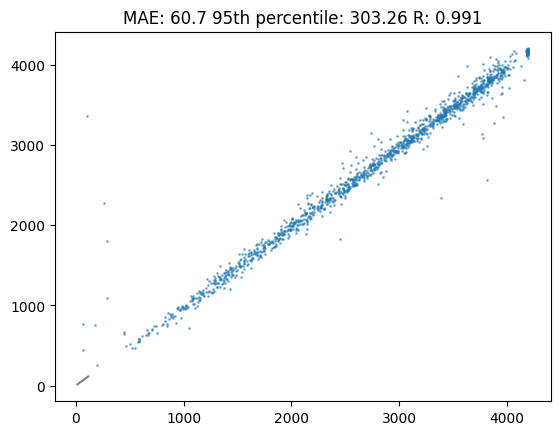

In [63]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()